Berikut merupakan library yang digunakan pada script ini:
-> Digunakan numpy untuk mengolah data karena Numpy menyediakan fungsi yang siap pakai untuk memudahkan kita melakukan perhitungan saintifik seperti matriks, aljabar, statistik, dan sebagainya.

-> Pandas digunakan untuk mengolah data menjadi bentuk tabular.

-> Matplotlib digunakan untuk melakukan visualisasi data.

-> Digunakan scipy untuk melakukan FFT

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm

In [2]:

#Fucntion for import data
for dirname, _, filenames in os.walk('Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Dataset/Healthy/h30hz80.csv
Dataset/Healthy/h30hz10.csv
Dataset/Healthy/h30hz90.csv
Dataset/Healthy/h30hz20.csv
Dataset/Healthy/h30hz40.csv
Dataset/Healthy/h30hz60.csv
Dataset/Healthy/h30hz50.csv
Dataset/Healthy/h30hz70.csv
Dataset/Healthy/h30hz30.csv
Dataset/Healthy/h30hz0.csv
Dataset/BrokenTooth/b30hz20.csv
Dataset/BrokenTooth/b30hz10.csv
Dataset/BrokenTooth/b30hz40.csv
Dataset/BrokenTooth/b30hz90.csv
Dataset/BrokenTooth/b30hz80.csv
Dataset/BrokenTooth/b30hz70.csv
Dataset/BrokenTooth/b30hz50.csv
Dataset/BrokenTooth/b30hz0.csv
Dataset/BrokenTooth/b30hz60.csv
Dataset/BrokenTooth/b30hz30.csv


In [3]:
dfs = []
for dirname, _, filenames in tqdm(os.walk('Dataset')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
sensor_readings = df.melt(
    id_vars=['sample_index','state','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

In [5]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

## Frequency Analysis

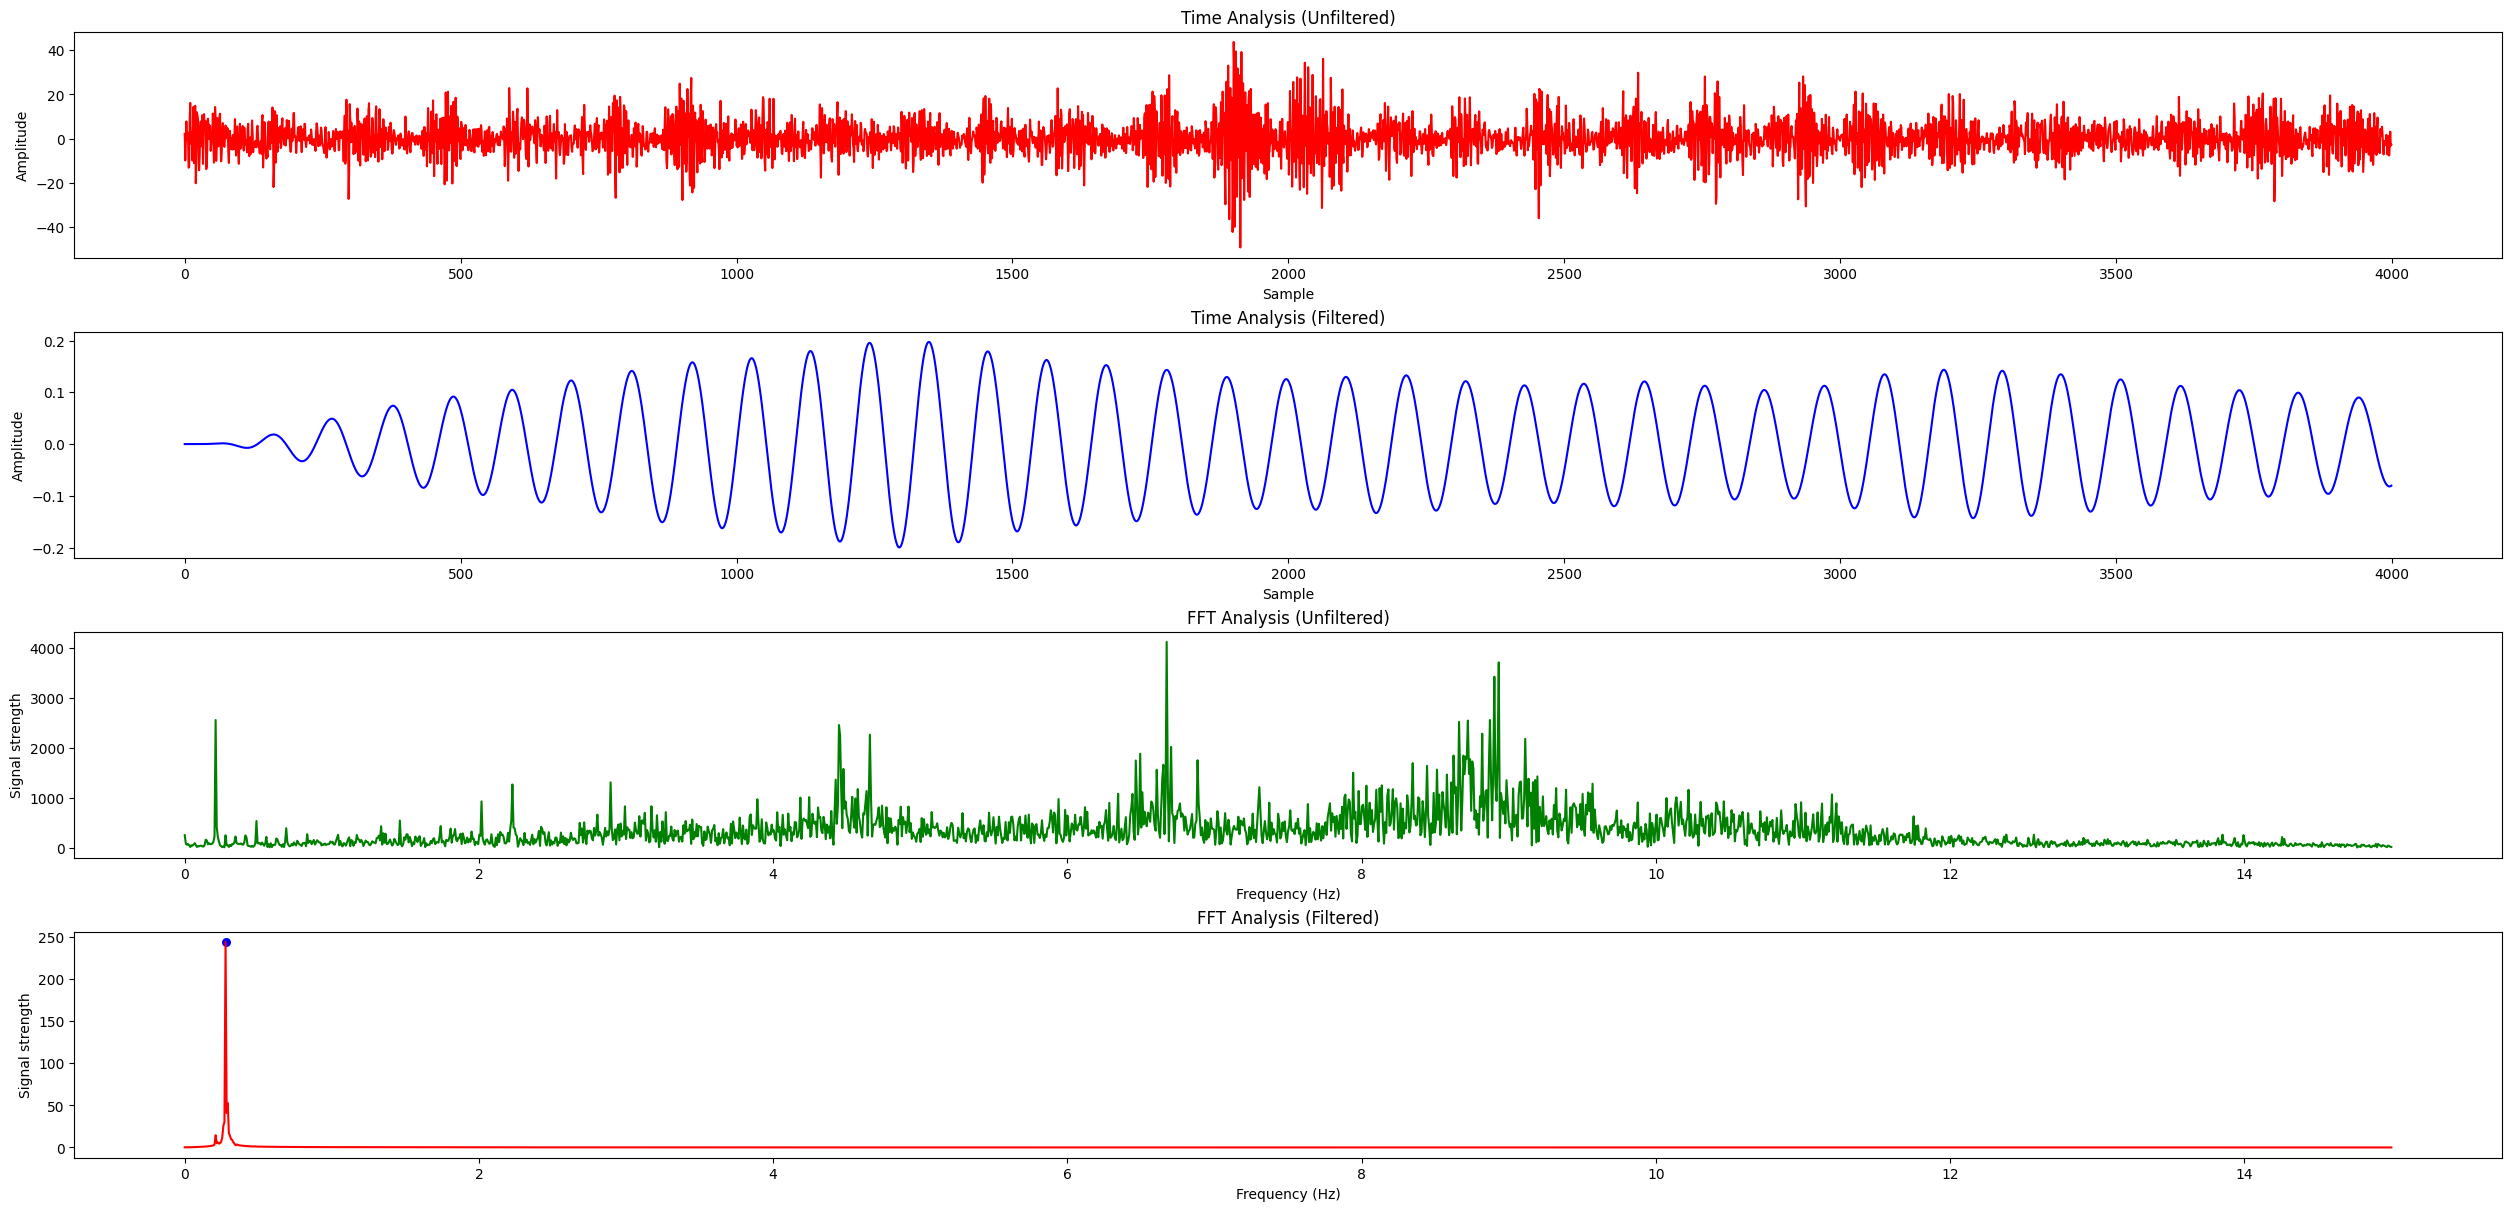

In [6]:
import scipy.signal

x = rdg(sensor_readings, 'h', 50, 'a1').reading.values[:4000]

b, a = scipy.signal.butter(3, [0.018,0.02],  btype='bandpass') #Filter
x_filtered = scipy.signal.lfilter(b, a, x)

y_nf = np.abs(fft.rfft(x))
x_nf = fft.rfftfreq(x.shape[0], 1/30) 

y_fft = np.abs(fft.rfft(x_filtered))
x_fft = fft.rfftfreq(x_filtered.shape[0], 1/30)  # 30Hz data rate

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y_fft.shape[0] / x_fft.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y_fft,0.99)

abnormal_peaks, _ = signal.find_peaks(y_fft, distance=x_peak_spacing, prominence=x_peak_prominence)



fig, ax = plt.subplots(4,1, figsize=(25,12), constrained_layout = True)
ax[0].plot(x, color='red')
ax[1].plot(x_filtered, color='blue')
ax[2].plot(x_nf, y_nf, color='green')
ax[3].plot(x_fft, y_fft, color='red')
for peak in abnormal_peaks:
    ax[3].scatter(x=x_fft[peak], y=y_fft[peak], c='b', marker='o', s=30)

# for xz in range(4):
#     if xz < 2:
#         ax[xz].set_title()
#         ax[xz].set_xlabel('Sample')
#         ax[xz].set_ylabel('Amplitude')
#     else:
#         ax[xz].set_xlabel('Frequency (Hz)')
#         ax[xz].set_ylabel('Signal strength')
ax[0].set_title("Time Analysis (Unfiltered)")
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Amplitude')

ax[1].set_title("Time Analysis (Filtered)")
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Amplitude')

ax[2].set_title("FFT Analysis (Unfiltered)")
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Signal strength')

ax[3].set_title("FFT Analysis (Filtered)")
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_ylabel('Signal strength')
plt.show()

## Neural Network Classification

In [7]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            #'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            'sensor_a4': int(sensor=='a4'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [8]:
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
data = scaler.fit_transform(data)
print(data)

[[0.         0.         0.         ... 0.19965077 0.51543001 0.        ]
 [0.         0.         0.         ... 0.08482046 0.45463775 0.        ]
 [0.         0.         0.         ... 0.23778072 0.565675   0.        ]
 ...
 [0.         0.         1.         ... 0.0913045  0.43189708 0.        ]
 [0.         0.         1.         ... 0.0681566  0.47789018 0.        ]
 [0.         0.         1.         ... 0.12918769 0.53597226 0.        ]]


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [41]:
#Import svm model
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       808
           1       0.69      0.79      0.74       800

    accuracy                           0.72      1608
   macro avg       0.72      0.72      0.72      1608
weighted avg       0.72      0.72      0.72      1608



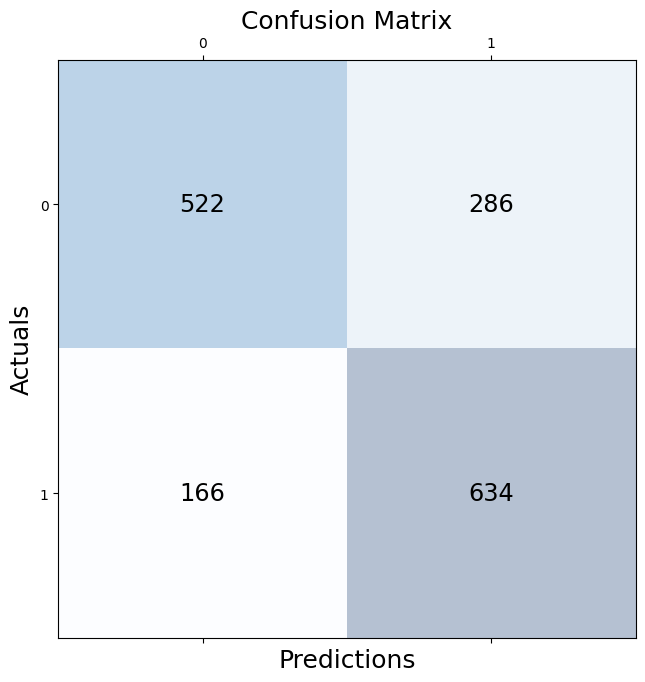

In [49]:
from sklearn.metrics import confusion_matrix

#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.731
Accuracy score (validation): 0.737
Learning rate:  0.075
Accuracy score (training): 0.743
Accuracy score (validation): 0.738
Learning rate:  0.1
Accuracy score (training): 0.758
Accuracy score (validation): 0.752
Learning rate:  0.25
Accuracy score (training): 0.784
Accuracy score (validation): 0.771
Learning rate:  0.5
Accuracy score (training): 0.808
Accuracy score (validation): 0.800
Learning rate:  0.75
Accuracy score (training): 0.818
Accuracy score (validation): 0.806
Learning rate:  1
Accuracy score (training): 0.819
Accuracy score (validation): 0.812


In [29]:
from tpot import TPOTClassifier

tpot_td = TPOTClassifier(generations=5, random_state=42, max_time_mins=2)
y_predict = tpot_td.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.3%}')

Best accuracy score: 87.127%


/home/norris/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [36]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, ConfusionMatrixDisplay, plot_confusion_matrix


In [32]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[522, 286],
       [166, 634]])

In [48]:
 
class_names=np.arange(10)#classes 0-9
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix)
plt.show()

/home/norris/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

<Figure size 640x480 with 0 Axes>